In [1]:
import sys
sys.path.append('../')
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model
from ATARI.ModelData.particle import Particle, Neutron
from ATARI.theory.resonance_statistics import log_likelihood

from ATARI.PiTFAll import fnorm

In [2]:
sammypath = "/Users/colefritsch/GitLab/Sammy/sammy/build/bin/sammy"

In [3]:
# %matplotlib widget

# Define generative models

Neutron induced reaction measurements using the time-of-flight method can be modelled using 3 primary categories:
1. A reaction model, represented here in ATARI the Particle_Pair class
2. An experimental model, represented here in ATARI by the Experimental_Model class
3. A reduction model, represented in ATARI by a Reduction_Model protocol

These three models attempt to describe everything that is happenning in one of these experiments. 
Traditionally, these models are used to analyze experimental data. 
The Syndat module of the ATARI code uses these models in a generative manner, producing statistical samples of experimental data.


## Reaction Model: Particle Pair class
Each of the 3 models can also be created outside and then added to the Generative Model container.
These ATARI classes have additional functionality if you want to work with them at this lower level.
The following code snippet demonstrates some of these capabilities.

In [4]:
Ta181 = Particle(Z=73, A=181, I=3.5, mass=180.94803, name='Ta181')
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [180,270],
                        ac = 0.8127,
                        target=Ta181,
                        projectile=Neutron,
                        l_max = 1
)

# print quant number map up to l_max
Ta_pair.map_quantum_numbers(print_out=True)

# J = 3, <D> = 9.0030 eV, <gn2> = 452.56615 meV, <gg2> = 32.0 meV
# J = 4, <D> = 8.3031 eV, <gn2> = 332.24347 meV, <gg2> = 32.0 meV

# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615, #46.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347, #35.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

print()
print("Interrogate spin group attribute:")
print(Ta_pair.spin_groups[3.0])


print()
print("Resonance ladder sampled from resonance statistics:")
print(Ta_pair.sample_resonance_ladder())


Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])

Interrogate spin group attribute:
{'Jpi': 3.0, 'J_ID': 1, '<D>': 9.003, '<gn2>': 452.56615, 'n_dof': 1, '<gg2>': 32.0, 'g_dof': 1000, 'quantiles': {'D01': 1.0184333135415593, 'D99': 21.80043460630884, 'gn01': 0.0710926470659408, 'gn99': 3002.729610372257, 'gg01': 28.765198301747624, 'gg99': 35.42300781927096, 'gt01': 28.836290948813566, 'gt99': 3038.152618191528}, 'chs': 1, 'Ls': [0]}

Resonance ladder sampled from resonance statistics:
             E         Gg        Gn1  J_ID        gg2          gn2  Jpi    L
0   188.717776 -65.454019 -50.549765   1.0 -32.727010 -1036.274050  3.0  0.0
1   192.353031 -63.619260   4.495719   1.0 -31.809630    91.287542  3.0  0.0
2   203.682014 -61.513256   0.372304   1.0 -30.756628     7.346549  3.0  0.0
3   210.341850  63.395392 -58.296180   1.0  31.697696 -1131.980998  3.0  0.0
4   219.090613 -63.934611 -

## Experimental Model class & Sammy

This class's primary purpose is to hold relevant experimental information used in calculating experimentally corrected resonance models with SAMMY.
The ATARI code come with a sammy-interface module that wraps around the sammy code. For more details on this interface, see the user example notebook. 
Before the Experimental_Model can be passed to syndat, the user must define the template parameter to be a path to a sammy input template. 

The sammy interface has a module for creating template input files from these generative models. 
The idea is that you make the template, inspect it manually, then give it to the experimental model class to be used with syndat

In [5]:
Ta_pair.expand_ladder()
Ta_pair.resonance_ladder

,E,Gg,Gn1,J_ID,gg2,gn2,Jpi,L
0,188.717776,-65.454019,-50.549765,1.0,-32.727010,-1036.274050,3.0,0.0
1,192.353031,-63.619260,4.495719,1.0,-31.809630,91.287542,3.0,0.0
2,203.682014,-61.513256,0.372304,1.0,-30.756628,7.346549,3.0,0.0
3,210.341850,63.395392,-58.296180,1.0,31.697696,-1131.980998,3.0,0.0
4,219.090613,-63.934611,-34.162973,1.0,-31.967306,-649.988475,3.0,0.0
5,226.392753,-63.081875,-35.324398,1.0,-31.540937,-661.158206,3.0,0.0
6,238.475062,69.951754,-0.078547,1.0,34.975877,-1.432411,3.0,0.0
7,249.584310,-63.984759,14.902821,1.0,-31.992379,265.657291,3.0,0.0
8,260.204169,64.177071,75.142479,1.0,32.088536,1311.868427,3.0,0.0
9,185.609962,59.850619,-0.241026,2.0,29.925309,-4.982251,4.0,0.0


In [6]:
# exp_descr_cap = Experimental_Model(title="cap",
#                                 reaction="capture", 
#                                 energy_range=[Give_Energy_Range_Here],
#                                 template=Path_to_template_here,
#                                 sammy_inputs={"ResFunc": 'ORRES'},
#                                 n = (0.005, 0.0),
#                                 FP = (75.00, 0.00),
#                                 t0 = (3326.0, 0.0), 
#                                 burst = (8.0,1.0),
#                                 temp = (300, 0.0),
#                                 channel_width_info={ # what should I put here?
#                                     "maxE": [270], 
#                                     "chw": [25.6],
#                                     "dchw": [0.8]
#                                 },
#                                 additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
#                             )

In [7]:

trans12mm_gen_exp = Experimental_Model(title = "T12mm", 
                                 reaction = "transmission", 
                                 energy_range = [200, 250], 
                                 template = None, 
                                 energy_grid = None, 
                                 n = (0.067166, 0.0), 
                                 FP = (35.185, 0.0), 
                                 t0 = (3326.0, 0.0), 
                                 burst = (10, 1.0), 
                                 temp = (300, 0.0), 
                                 channel_widths = { 
                                     "maxE": [300],
                                     "chw": [100.0],
                                     "dchw": [0.8]
                                 }
)

cap12mm_gen_exp = Experimental_Model(title = "Y12mm", 
                                 reaction = "capture", 
                                 energy_range = [200, 250], 
                                 template = None, 
                                # template = os.path.realpath("/Users/noahwalton/Documents/GitHub/ATARI/ATARI/sammy_interface/sammy_templates/allexpcap_1sg.inp"),
                                 energy_grid = None, 
                                 n = (0.067166, 0.0), 
                                 FP = (35.185, 0.0), 
                                 t0 = (3326.0, 0.0), 
                                 burst = (10, 1.0), 
                                 temp = (300, 0.0), 
                                 channel_widths = { 
                                     "maxE": [300],
                                     "chw": [100.0],
                                     "dchw": [0.8]
                                 }
)
# trans12mm_gen_exp = Experimental_Model(title = "T12mm", 
#                                  reaction = "transmission", 
#                                  energy_range = [200, 250], 
#                                  template = None, 
#                                  energy_grid = None, 
#                                  n = (0.067166, 0.0), 
#                                  FP = (35.185, 0.0), 
#                                  t0 = (3326.0, 0.0), 
#                                  burst = (10, 1.0), 
#                                  temp = (300, 0.0), 
#                                  channel_widths = { 
#                                      "maxE": [300],
#                                      "chw": [100.0],
#                                      "dchw": [0.8]
#                                  }
# )

# cap12mm_gen_exp = Experimental_Model(title = "Y12mm", 
#                                  reaction = "capture", 
#                                  energy_range = [200, 250], 
#                                  template = None, 
#                                 # template = os.path.realpath("/Users/noahwalton/Documents/GitHub/ATARI/ATARI/sammy_interface/sammy_templates/allexpcap_1sg.inp"),
#                                  energy_grid = None, 
#                                  n = (0.067166, 0.0), 
#                                  FP = (35.185, 0.0), 
#                                  t0 = (3326.0, 0.0), 
#                                  burst = (10, 1.0), 
#                                  temp = (300, 0.0), 
#                                  channel_widths = { 
#                                      "maxE": [300],
#                                      "chw": [100.0],
#                                      "dchw": [0.8]
#                                  }
# )


sammy_rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                              Print        = True,
                                              bayes        = False,
                                              keep_runDIR  = True,
                                              sammy_runDIR = "sammy_runDIR_1")

template_creator.make_input_template(
    'template_T.inp', Ta_pair, trans12mm_gen_exp, sammy_rto)

template_creator.make_input_template(
    'template_Y.inp', Ta_pair, cap12mm_gen_exp, sammy_rto)


cap12mm_gen_exp.template = os.path.realpath('template_Y.inp')

trans12mm_gen_exp.template = os.path.realpath('template_T.inp')

In [8]:
cap12mm_gen_exp.sammy_inputs

{'alphanumeric': ['USE MULTIPLE SCATTERING',
  'INFINITE SLAB',
  'NORMALIZE AS YIELD Rather than cross section',
  'BROADENING IS WANTED',
  'DO NOT SHIFT RPI RESOLUTION'],
 'ResFunc': 'RPI C'}

## Measurement models

Syndat needs both a generative and reductive measurement model. 
The generative model is considered 'true' and is used to generate statistical samples of raw experimental observables. 
These raw observables, however, are not used directly in evaluations, rather they are put through a data reduction model to get an object like experimental transmission or capture yield. 
By defining both a generative and reductive measurment model, Syndat can be used to investigate the impact of incorrectly specified measurement models/parameters used in the data reduction process.



In [9]:
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.ModelData.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT

# trans12mm_gen_meas = Transmission_RPI(trigo=trigo, trigs=trigs)
# trans12mm_red_meas = Transmission_RPI(trigo=trigo, trigs=trigs)
trans12mm_gen_meas = Transmission_RPI()
trans12mm_red_meas = Transmission_RPI()
trans12mm_red_meas.approximate_unknown_data(exp_model=trans12mm_gen_exp, smooth=False, check_trig=True)
trans12mm_gen_meas.approximate_unknown_data(exp_model=trans12mm_gen_exp, smooth=False, check_trig=True)

cap12mm_gen_meas = Capture_Yield_RPI()
cap12mm_red_meas = Capture_Yield_RPI()
cap12mm_red_meas.approximate_unknown_data(exp_model=cap12mm_gen_exp, smooth=False, check_trig=True)
cap12mm_gen_meas.approximate_unknown_data(exp_model=cap12mm_gen_exp, smooth=False, check_trig=True)

## Sampling from Syndat

The syndat class contains all necessary model information. 
It also takes a syndat options class which can be instantiated with default settings.
Once you've constructed your syndat model, the sample method can be used to draw any number of samples.
This method takes either a sammyRTO arguement or a pw_true arguement. 
If pw_true is given, this will be taken as the true experimental function around with measurement data will be sampled. 
Usually the user will provide a sammyRTO instead which will allow the true experimental function to be reconstructed by sammy.
This also allows new resonance ladders to be sampled each time.


In [10]:
synOPT = syndatOPT(calculate_covariance=True)
synOPT 

calculate_covariance: True
explicit_covariance: False
force_zero_to_1: True
sampleRES: True
sampleTMP: True
sampleTNCS: True
sample_counting_noise: True
save_raw_data: False
smoothTNCS: False

In [11]:
synOPT.calculate_covariance = True
syndat_trans12mm = Syndat_Model(trans12mm_gen_exp,
                            trans12mm_gen_meas,
                            trans12mm_red_meas,
                            options = synOPT,
                            title='trans12mm')
syndat_trans12mm.sample(Ta_pair, 
                    sammyRTO=sammy_rto,
                    num_samples=1)

synOPT.calculate_covariance = False
syndat_cap12mm = Syndat_Model(cap12mm_gen_exp,
                            cap12mm_gen_meas,
                            cap12mm_red_meas,
                            options = synOPT,
                            title='cap12mm')
syndat_cap12mm.sample(Ta_pair, 
                    sammyRTO=sammy_rto,
                    num_samples=1)

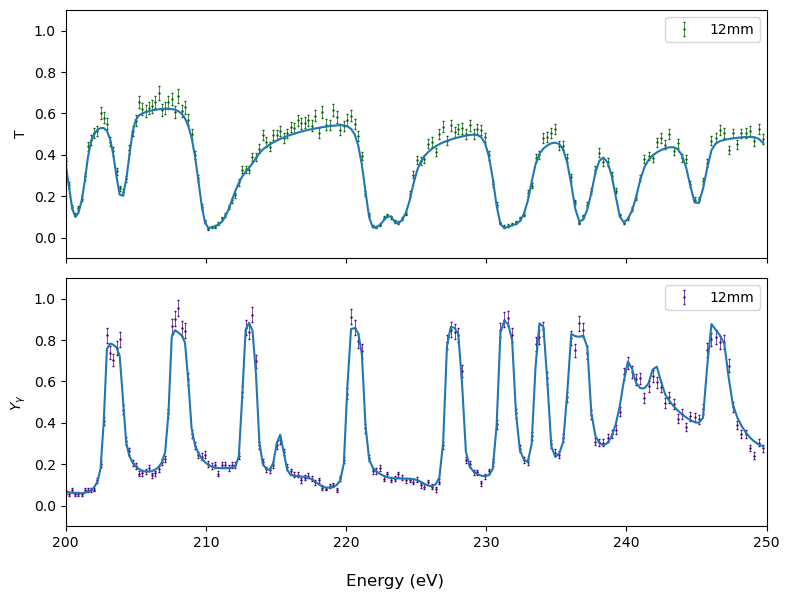

In [12]:
dataT = syndat_trans12mm.samples[0].pw_reduced
dataY = syndat_cap12mm.samples[0].pw_reduced

### Plot 
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

### Trans
axes[0].errorbar(dataT.E, dataT.exp, yerr=dataT.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

axes[0].plot(dataT.E, dataT.true)
axes[0].set_ylabel("T")

# ### Capture
axes[1].errorbar(dataY.E, dataY.exp, yerr=dataY.exp_unc, zorder=0, 
                                        fmt='.', color='indigo', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')
axes[1].plot(dataY.E, dataY.true)

axes[1].set_ylabel(r"$Y_{\gamma}$")

### make it pretty
for ax in axes:
    ax.set_xlim([200,250])
    ax.set_ylim([-0.1,1.1])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

In [13]:
F_min    = np.inf
chi2_min = np.inf
sammy_out_chi2_min = None
sammy_out_F_min    = None
bounds = (200.0, 250.0)
for iter in range(10):
    # Changing spingroups inside the ladder:
    res_ladder_fit = Ta_pair.resonance_ladder
    res_ladder_fit[['varyE','varyGg','varyGn1']] = 1
    subset_bools = (res_ladder_fit['E'] > bounds[0]) & (res_ladder_fit['E'] < bounds[1])
    sgs = np.random.randint(0, 2, size=sum(subset_bools))
    res_ladder_fit.loc[subset_bools, 'J_ID'] = np.array([1.0, 2.0])[sgs]
    res_ladder_fit.loc[subset_bools, 'Jpi' ] = np.array([3.0, 4.0])[sgs]

    sammyINP = sammy_classes.SammyInputData(Ta_pair,
                                            res_ladder_fit,
                                            os.path.realpath('template_T.inp'),
                                            trans12mm_gen_exp,
                                            experimental_data = dataT,
                                            energy_grid = trans12mm_gen_exp.energy_grid,
                                            initial_parameter_uncertainty=1.0)

    sammy_rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                                Print        = True,
                                                bayes        = True,
                                                keep_runDIR  = True,
                                                iterations   = 10,
                                                sammy_runDIR = "sammy_runDIR")
    sammy_out = sammy_functions.run_sammy(sammyINP, sammy_rto)
    
    chi2_out = sammy_out.chi2_post
    if chi2_out < chi2_min:
        chi2_min = chi2_out
        sammy_out_chi2_min = copy(sammy_out)

    F_out = chi2_out + 2.0*log_likelihood(Ta_pair, res_ladder_fit, bounds)
    if F_out < F_min:
        F_min = F_out
        sammy_out_F_min    = copy(sammy_out)

print(sammy_out_chi2_min.chi2_post, sammy_out_F_min.chi2_post)

67227.9 67227.9


In [14]:
reactions = ['transmission',]
template  = sammyINP.template
temp = 300.0

# Chi2
ResidualMatrixDict, _ = fnorm.build_residual_matrix_dict([sammy_out_chi2_min.par_post], [Ta_pair.resonance_ladder], sammypath, Ta_pair, (200.0, 250.0), temp, template, reactions)
obj = fnorm.calculate_fnorms(ResidualMatrixDict, reactions)
print(obj)

# F
ResidualMatrixDict, _ = fnorm.build_residual_matrix_dict([sammy_out_F_min.par_post], [Ta_pair.resonance_ladder], sammypath, Ta_pair, (200.0, 250.0), temp, template, reactions)
obj = fnorm.calculate_fnorms(ResidualMatrixDict, reactions)
print(obj)

{'transmission': 0.591693816943815}
{'transmission': 0.591693816943815}


## Syndat control module for multiple datasets

The above example shows how to build and sample from a complete syndat model for one experimental dataset. 
It showcases both transmission and capture yield measurement models, however, these are not used together.
Immediately, you can see how it would be more useful to generate multiple data types from the same set of resonance parameters.

The Syndat Control Module can be used to build and sample from several correlated syndat models at once.
The default correlation between datasets is to use a common reaction model (resonance ladder) to emulate multiple measurements of the same isotope.
Generating data with the Syndat Control Module will automatically use the same resonance ladder for each syndat model you give it.
<!-- 
### First, put each of these syndat models into the control module class -->

<!-- Options can be redefined here, each respective syndat model will take on the new options. -->
<!-- 1. sample resonance ladder
For all models/datasets:
2. sample correlated parameters
3. sample uncorrelated parameters
4. generate raw data 
5. reduce raw data -->

In [15]:
from ATARI.syndat.control import Syndat_Control

syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models= [syndat_trans12mm, syndat_cap12mm],
                        model_correlations=None,
                        options=synOPT
                        )

syndat.sample(sammy_rto, num_samples=2)
sample1 = syndat.get_sample(1)
sample1

TypeError: Syndat_Control.__init__() got an unexpected keyword argument 'options'

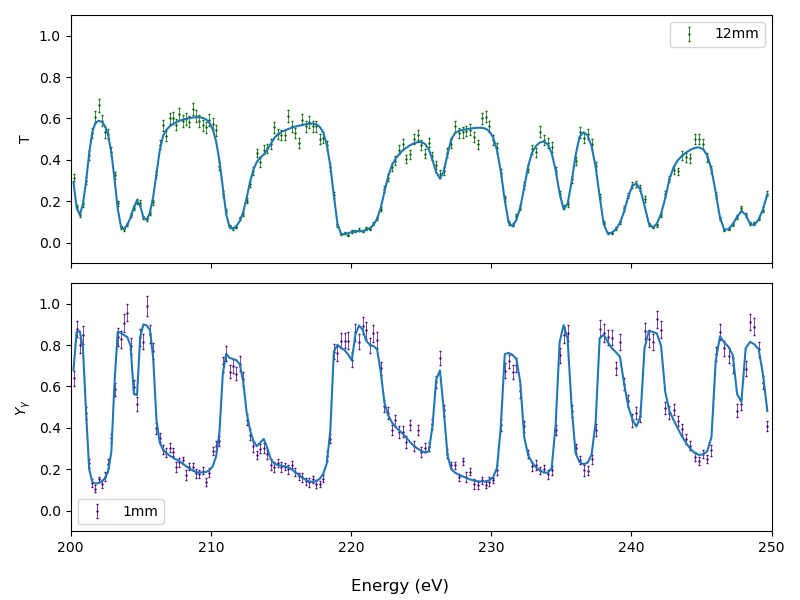

In [ ]:

### Plot 
fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

### Trans
axes[0].errorbar(sample1['trans12mm'].pw_reduced.E, sample1['trans12mm'].pw_reduced.exp, yerr=sample1['trans12mm'].pw_reduced.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

axes[0].plot(sample1['trans12mm'].pw_reduced.E, sample1['trans12mm'].pw_reduced.true)
axes[0].set_ylabel("T")

### Capture
axes[1].errorbar(sample1['cap12mm'].pw_reduced.E, sample1['cap12mm'].pw_reduced.exp, yerr=sample1['cap12mm'].pw_reduced.exp_unc, zorder=0, 
                                        fmt='.', color='indigo', linewidth=0.5, markersize=1.5, capsize=1, label='1mm')
axes[1].plot(sample1['cap12mm'].pw_reduced.E, sample1['cap12mm'].pw_reduced.true)

axes[1].set_ylabel(r"$Y_{\gamma}$")

### make it pretty
for ax in axes:
    ax.set_xlim([200,250])
    ax.set_ylim([-0.1,1.1])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

In [ ]:
sample1['trans12mm'].covariance_data

{'Cov_sys': array([[1.14395753e+03, 1.42659922e-01, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [1.42659922e-01, 2.19135003e-05, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.77123621e-04, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.11002928e-03,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.00000000e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.000000

### Correlated Experiments

This module also allows experimental correlations between datasets to be included, such as normalizing capture yields to the same detector yield. 
This behavior is not default and must be described in the model_correlations input.
The model_correlations input is a dictionary with keys that indicate the parameter and values that are tuples of (mean, uncertainty).
These values correspond to the measurement model parameters and, if given, 

In [ ]:
test = {'011': {'trigs':(10000,0)}}

for i in test.keys():
    print([int(each) for each in list(i)])


[0, 1, 1]


In [ ]:
trans12mm_gen_meas

Measurement model (data reduction) parameters:
{'trigo': (9758727, 0), 'trigs': (18476117, 0), 'm1': (1, 0.016), 'm2': (1, 0.008), 'm3': (1, 0.018), 'm4': (1, 0.005), 'ks': (0.563, 0.02402339737495515), 'ko': (1.471, 0.05576763648617445), 'b0s': (9.9, 0.1), 'b0o': (13.4, 0.7), 'a_b': ([582.7768594580712, 0.05149689096209191], [[1143.95753, 0.142659922], [0.142659922, 2.19135003e-05]]), 'open_neutron_spectrum':                tof            bw     c         dc           E
0    183110.960936  9.999999e-08  1217  34.885527  200.200037
1    183010.960948  9.999998e-08  1184  34.409301  200.422933
2    182910.960963  1.000001e-07  1200  34.641016  200.646202
3    182810.960863  9.999996e-08  1164  34.117444  200.869845
4    182710.960904  1.000001e-07  1209  34.770677  201.093861
..             ...           ...   ...        ...         ...
184  164710.960895  9.999999e-08  1304  36.110940  248.453308
185  164610.960907  9.999995e-08  1206  34.727511  248.761496
186  164510.960956  1.000000